In [ ]:
!pip install torch torchvision torchaudio
!pip install scikit-learn
!pip install kagglehub
!pip install opencv-python
!pip install matplotlib
!pip install tqdm


In [ ]:
import kagglehub

dataset_path = kagglehub.dataset_download("anirudhcv/labeled-optical-coherence-tomography-oct")
print("Path to dataset files:", dataset_path)


100%|██████████| 6.70G/6.70G [05:18<00:00, 22.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2


In [ ]:
import os

source_folder = "/root/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2/Dataset - train+val+test"
print("Contents of source folder:", os.listdir(source_folder))


Contents of source folder: ['train', 'test', 'val']


In [ ]:
import os

base_path = "/root/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2"
print("Base folder contents:", os.listdir(base_path))


Base folder contents: ['Dataset - train+val+test']


In [ ]:
import os

base_path = "/root/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2"
source_folder = os.path.join(base_path, "Dataset - train+val+test")
split_folder  = os.path.join(base_path, "OCT_split")

os.makedirs(split_folder, exist_ok=True)


In [ ]:
import os

base_path = "/root/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2/Dataset - train+val+test"

train_dir = os.path.join(base_path, "train")
val_dir   = os.path.join(base_path, "val")
test_dir  = os.path.join(base_path, "test")

print("Train classes:", os.listdir(train_dir))
print("Validation classes:", os.listdir(val_dir))
print("Test classes:", os.listdir(test_dir))


Train classes: ['DRUSEN', 'CNV', 'DME', 'NORMAL']
Validation classes: ['DRUSEN', 'CNV', 'DME', 'NORMAL']
Test classes: ['DRUSEN', 'CNV', 'DME', 'NORMAL']


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
val_data   = datasets.ImageFolder(val_dir, transform=val_transforms)
test_data  = datasets.ImageFolder(test_dir, transform=val_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32)
test_loader  = DataLoader(test_data, batch_size=32)

print("Number of training images:", len(train_data))
print("Number of validation images:", len(val_data))
print("Number of test images:", len(test_data))


from collections import Counter

def count_per_class(dataset, split_name):
    counts = Counter([dataset.classes[label] for _, label in dataset.samples])
    print(f"\n{split_name} class distribution:")
    for cls, count in counts.items():
        print(f"  {cls}: {count}")

count_per_class(train_data, "Train")
count_per_class(val_data, "Validation")
count_per_class(test_data, "Test")


Number of training images: 76515
Number of validation images: 21861
Number of test images: 10933

Train class distribution:
  CNV: 26218
  DME: 8118
  DRUSEN: 6206
  NORMAL: 35973

Validation class distribution:
  CNV: 7491
  DME: 2319
  DRUSEN: 1773
  NORMAL: 10278

Test class distribution:
  CNV: 3746
  DME: 1161
  DRUSEN: 887
  NORMAL: 5139


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ------------------------
# Define OCTLiteNet model
# ------------------------
class OCTLiteNet(nn.Module):
    def __init__(self, num_classes=4):
        super(OCTLiteNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # 3 → 16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 224 → 112

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # 16 → 32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 112 → 56

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 32 → 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 56 → 28

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # 64 → 128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 28 → 14
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 14 * 14, 256),  # Flatten to FC
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)     # Final classes (4)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.classifier(x)
        return x




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# === FIXED: define device, instantiate model, and set loss & optimizer BEFORE training ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Make sure the OCTLiteNet class and the train/val loaders exist before running this cell.
try:
    _ = OCTLiteNet
except NameError:
    raise RuntimeError('Define OCTLiteNet class before running the training setup cell.')
try:
    _ = train_data
    _ = train_loader
    _ = val_loader
except NameError:
    raise RuntimeError('Build train/val DataLoaders before running the training setup cell.')

model = OCTLiteNet(num_classes=len(train_data.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

print('Device:', device)
print('Model initialized with', len(train_data.classes), 'classes.')


Device: cuda
Model initialized with 4 classes.


In [ ]:
# === INTERMEDIATE RESULTS DURING TRAINING (TRAIN SET ONLY) ===
import os, random
import torch
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from torchvision.utils import save_image
from google.colab import drive

# 1) Mount Drive and create base output dir
drive.mount('/content/drive')
results_dir = "/content/drive/MyDrive/OCT_Intermediate_Results_part2"
os.makedirs(results_dir, exist_ok=True)

# 2) Helper: denormalize a 3xHxW tensor to [0,1] for visualization
def denormalize(img_tensor: torch.Tensor) -> torch.Tensor:
    img = img_tensor.clone().cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean
    return img.clamp(0, 1)

# 3) Helper: convert feature maps [C,H,W] → heatmap [H,W] (mean across channels, min-max scaled)
def fmap_to_heatmap(fmap: torch.Tensor):
    x = fmap.mean(dim=0)  # [H,W]
    x = (x - x.min()) / (x.max() - x.min() + 1e-6)
    return x.cpu().numpy()

# 4) Print training class distribution (requested)
train_counts = Counter([train_data.classes[label] for _, label in train_data.samples])
print("\nTraining class distribution:")
for cls in train_data.classes:
    print(f"  {cls}: {train_counts.get(cls, 0)}")

# 5) Precompute paths per class from TRAIN set (for sampling 5 each epoch)
paths_by_label = {i: [] for i in range(len(train_data.classes))}
for path, label in train_data.samples:
    paths_by_label[label].append(path)

# 6) Register forward hooks on early & late convs to capture intermediate feature maps
activations = {}
def get_activation(name):
    def hook(_module, _inp, out):
        activations[name] = out.detach()
    return hook

# Conv layers positions in OCTLiteNet.features:
# 0: Conv2d(3,16,...)   12: Conv2d(64,128,...)
h1 = model.features[0].register_forward_hook(get_activation("conv1"))
h2 = model.features[12].register_forward_hook(get_activation("conv4"))

# 7) TRAINING LOOP (same as yours, with intermediate saving at epoch end)
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_acc:.2f}%")

    # ---------- SAVE 20 INTERMEDIATE RESULTS (TRAIN ONLY): 5 per class ----------
    model.eval()
    epoch_folder = os.path.join(results_dir, f"epoch_{epoch+1:02d}")
    os.makedirs(epoch_folder, exist_ok=True)

    # sample 5 images per class from TRAIN set
    selected = {}
    for label_idx, paths in paths_by_label.items():
        k = min(5, len(paths))
        selected[label_idx] = random.sample(paths, k) if k > 0 else []

    # For each selected image: run forward, get preds + feature maps, save figure
    with torch.no_grad():
        for label_idx, paths in selected.items():
            true_cls = train_data.classes[label_idx]
            for i, img_path in enumerate(paths, start=1):
                img = Image.open(img_path).convert("RGB")
                x = train_transforms(img).unsqueeze(0).to(device)  # use TRAIN transforms as requested

                logits = model(x)
                probs = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
                pred_idx = int(probs.argmax())
                pred_cls = train_data.classes[pred_idx]
                conf = float(probs[pred_idx])

                # Grab intermediate activations from hooks for THIS forward pass
                conv1 = activations.get("conv1")  # [B,C,H,W] on device
                conv4 = activations.get("conv4")
                # Reduce to [H,W] heatmaps
                hm1 = fmap_to_heatmap(conv1[0]) if conv1 is not None else None
                hm4 = fmap_to_heatmap(conv4[0]) if conv4 is not None else None

                # Prepare figure: [Input | Early fmap | Late fmap]
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                fig.suptitle(f"True: {true_cls} | Pred: {pred_cls} ({conf:.2f})", fontsize=12)

                # Input image (denormalized)
                axs[0].imshow(denormalize(x[0]).permute(1, 2, 0).numpy())
                axs[0].set_title("Input (train-preprocessed)")
                axs[0].axis("off")

                # Early conv heatmap
                if hm1 is not None:
                    axs[1].imshow(denormalize(x[0]).permute(1, 2, 0).numpy())
                    axs[1].imshow(hm1, alpha=0.5)
                    axs[1].set_title("Early features (conv1)")
                else:
                    axs[1].text(0.5, 0.5, "N/A", ha='center', va='center')
                    axs[1].set_title("Early features (conv1)")
                axs[1].axis("off")

                # Late conv heatmap
                if hm4 is not None:
                    axs[2].imshow(denormalize(x[0]).permute(1, 2, 0).numpy())
                    axs[2].imshow(hm4, alpha=0.5)
                    axs[2].set_title("Late features (conv4)")
                else:
                    axs[2].text(0.5, 0.5, "N/A", ha='center', va='center')
                    axs[2].set_title("Late features (conv4)")
                axs[2].axis("off")

                # Save to Drive (filename includes true/pred info)
                out_name = f"{true_cls}_true__{pred_cls}_pred__{i:02d}.png"
                out_path = os.path.join(epoch_folder, out_name)
                plt.savefig(out_path, bbox_inches="tight", dpi=150)
                plt.close(fig)

    print(f"Saved intermediate results for Epoch {epoch+1} to: {epoch_folder}")

# 8) Clean up hooks
h1.remove()
h2.remove()


Mounted at /content/drive

Training class distribution:
  CNV: 26218
  DME: 8118
  DRUSEN: 6206
  NORMAL: 35973


Epoch 1/15: 100%|██████████| 2392/2392 [10:24<00:00,  3.83it/s]


Epoch [1/15], Loss: 0.6875, Train Accuracy: 77.10%
Saved intermediate results for Epoch 1 to: /content/drive/MyDrive/OCT_Intermediate_Results_part2/epoch_01


Epoch 2/15: 100%|██████████| 2392/2392 [09:36<00:00,  4.15it/s]


Epoch [2/15], Loss: 0.5271, Train Accuracy: 82.12%
Saved intermediate results for Epoch 2 to: /content/drive/MyDrive/OCT_Intermediate_Results_part2/epoch_02


Epoch 3/15: 100%|██████████| 2392/2392 [09:24<00:00,  4.24it/s]


Epoch [3/15], Loss: 0.4031, Train Accuracy: 86.42%
Saved intermediate results for Epoch 3 to: /content/drive/MyDrive/OCT_Intermediate_Results_part2/epoch_03


Epoch 4/15: 100%|██████████| 2392/2392 [09:25<00:00,  4.23it/s]


Epoch [4/15], Loss: 0.2613, Train Accuracy: 91.63%
Saved intermediate results for Epoch 4 to: /content/drive/MyDrive/OCT_Intermediate_Results_part2/epoch_04


Epoch 5/15: 100%|██████████| 2392/2392 [09:28<00:00,  4.21it/s]


Epoch [5/15], Loss: 0.2058, Train Accuracy: 93.40%
Saved intermediate results for Epoch 5 to: /content/drive/MyDrive/OCT_Intermediate_Results_part2/epoch_05


Epoch 6/15: 100%|██████████| 2392/2392 [09:27<00:00,  4.22it/s]


Epoch [6/15], Loss: 0.1869, Train Accuracy: 93.98%
Saved intermediate results for Epoch 6 to: /content/drive/MyDrive/OCT_Intermediate_Results_part2/epoch_06


Epoch 7/15: 100%|██████████| 2392/2392 [09:29<00:00,  4.20it/s]


Epoch [7/15], Loss: 0.1796, Train Accuracy: 94.30%
Saved intermediate results for Epoch 7 to: /content/drive/MyDrive/OCT_Intermediate_Results_part2/epoch_07


Epoch 8/15: 100%|██████████| 2392/2392 [09:28<00:00,  4.21it/s]


Epoch [8/15], Loss: 0.1663, Train Accuracy: 94.56%
Saved intermediate results for Epoch 8 to: /content/drive/MyDrive/OCT_Intermediate_Results_part2/epoch_08


Epoch 9/15: 100%|██████████| 2392/2392 [09:25<00:00,  4.23it/s]


Epoch [9/15], Loss: 0.1604, Train Accuracy: 94.83%
Saved intermediate results for Epoch 9 to: /content/drive/MyDrive/OCT_Intermediate_Results_part2/epoch_09


Epoch 10/15: 100%|██████████| 2392/2392 [09:23<00:00,  4.25it/s]


Epoch [10/15], Loss: 0.1532, Train Accuracy: 94.98%
Saved intermediate results for Epoch 10 to: /content/drive/MyDrive/OCT_Intermediate_Results_part2/epoch_10


Epoch 11/15: 100%|██████████| 2392/2392 [09:23<00:00,  4.24it/s]


Epoch [11/15], Loss: 0.1522, Train Accuracy: 95.03%
Saved intermediate results for Epoch 11 to: /content/drive/MyDrive/OCT_Intermediate_Results_part2/epoch_11


Epoch 12/15: 100%|██████████| 2392/2392 [09:22<00:00,  4.25it/s]


Epoch [12/15], Loss: 0.1473, Train Accuracy: 95.15%
Saved intermediate results for Epoch 12 to: /content/drive/MyDrive/OCT_Intermediate_Results_part2/epoch_12


Epoch 13/15: 100%|██████████| 2392/2392 [09:23<00:00,  4.25it/s]


Epoch [13/15], Loss: 0.1456, Train Accuracy: 95.27%
Saved intermediate results for Epoch 13 to: /content/drive/MyDrive/OCT_Intermediate_Results_part2/epoch_13


Epoch 14/15: 100%|██████████| 2392/2392 [09:24<00:00,  4.24it/s]


Epoch [14/15], Loss: 0.1452, Train Accuracy: 95.30%
Saved intermediate results for Epoch 14 to: /content/drive/MyDrive/OCT_Intermediate_Results_part2/epoch_14


Epoch 15/15: 100%|██████████| 2392/2392 [09:22<00:00,  4.25it/s]


Epoch [15/15], Loss: 0.1481, Train Accuracy: 95.31%
Saved intermediate results for Epoch 15 to: /content/drive/MyDrive/OCT_Intermediate_Results_part2/epoch_15


In [ ]:

save_path = "/content/octlitenet_best01.pth"

torch.save({
    "state_dict": model.state_dict(),
    "class_to_idx": train_data.class_to_idx
}, save_path)

print("Saved OCTLiteNet model at:", save_path)


Saved OCTLiteNet model at: /content/octlitenet_best01.pth


In [ ]:
checkpoint = torch.load("/content/octlitenet_best01.pth", map_location=device)


model = OCTLiteNet(num_classes=len(train_data.classes)).to(device)
model.load_state_dict(checkpoint["state_dict"])


class_to_idx = checkpoint["class_to_idx"]
idx_to_class = {v: k for k, v in class_to_idx.items()}
print("Loaded model with classes:", idx_to_class)


Loaded model with classes: {0: 'CNV', 1: 'DME', 2: 'DRUSEN', 3: 'NORMAL'}


In [ ]:
# ------------------------
# 4. Corrected Evaluation and Loading
# ------------------------
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate(model, loader, class_names, device):
    # This function expects an instance of the model, not the class name
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            y_pred.extend(preds.cpu().numpy().tolist())
            y_true.extend(y.cpu().numpy().tolist())

    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc*100:.2f}%\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    return acc

# Load the model from the saved checkpoint
checkpoint = torch.load("/content/octlitenet_best01.pth", map_location=device)
model_eval = OCTLiteNet(num_classes=len(train_data.classes)).to(device)
model_eval.load_state_dict(checkpoint["state_dict"])
model_eval.eval()

# Run Validation & Testing with the INSTANCE of the model
print("== Validation on OCTLiteNet ==")
val_acc = evaluate(model_eval, val_loader, train_data.classes, device)

print("\n== Testing on OCTLiteNet ==")
test_acc = evaluate(model_eval, test_loader, train_data.classes, device)


== Validation on OCTLiteNet ==
Accuracy: 94.36%

              precision    recall  f1-score   support

         CNV     0.9590    0.9606    0.9598      7491
         DME     0.9790    0.7822    0.8696      2319
      DRUSEN     0.8853    0.7659    0.8213      1773
      NORMAL     0.9353    0.9982    0.9657     10278

    accuracy                         0.9436     21861
   macro avg     0.9396    0.8768    0.9041     21861
weighted avg     0.9440    0.9436    0.9418     21861

Confusion matrix:
 [[ 7196    36   166    93]
 [  111  1814     6   388]
 [  185     1  1358   229]
 [   12     2     4 10260]]

== Testing on OCTLiteNet ==
Accuracy: 94.18%

              precision    recall  f1-score   support

         CNV     0.9600    0.9600    0.9600      3746
         DME     0.9723    0.7873    0.8701      1161
      DRUSEN     0.8990    0.7430    0.8136       887
      NORMAL     0.9300    0.9979    0.9627      5139

    accuracy                         0.9418     10933
   macro avg   

In [ ]:

model = OCTLiteNet(num_classes=4)


total_params = sum(p.numel() for p in model.parameters())

print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 6,521,732


In [ ]:

param_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
model_size_mb = param_size_bytes / (1024**2)

print(f"Model size: {model_size_mb:.2f} MB")

Model size: 24.88 MB


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from google.colab import files
import os

# ------------------------
# Define OCTLiteNet model
# ------------------------
class OCTLiteNet(nn.Module):
    def __init__(self, num_classes=4):
        super(OCTLiteNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 14 * 14, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# ------------------------
# Device and transforms
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


# ------------------------
# Load trained OCTLiteNet
# ------------------------
ckpt_path = "/content/octlitenet_best01.pth"
checkpoint = torch.load(ckpt_path, map_location=device)

model = OCTLiteNet(num_classes=4).to(device)
model.load_state_dict(checkpoint["state_dict"])
model.eval()

# Restore class mapping
class_to_idx = checkpoint["class_to_idx"]
idx_to_class = {v: k for k, v in class_to_idx.items()}
print("Loaded class index mapping:", class_to_idx)


# ------------------------
# Biomarker + disease mapping
# ------------------------
biomarker_map = {
    "CNV": "Choroidal neovascularization (abnormal subretinal vessels)",
    "DME": "Intraretinal cysts / retinal thickening / fluid",
    "DRUSEN": "Sub-RPE drusen deposits ± RPE irregularities",
    "NORMAL": "No abnormal biomarkers detected"
}
disease_map = {
    "CNV": "Age-related macular degeneration (wet AMD)",
    "DME": "Diabetic macular edema (complication of diabetic retinopathy)",
    "DRUSEN": "Age-related macular degeneration (early/intermediate stage)",
    "NORMAL": "Healthy retina"
}


# ------------------------
# Prediction function
# ------------------------
def predict_image(image_path, show_probs=True, threshold=0.90):
    try:
        img = Image.open(image_path).convert("RGB")
    except Exception as e:
        return f"Cannot open {image_path}: {e}"

    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred_idx = int(probs.argmax())
        pred_class = idx_to_class[pred_idx]
        conf = float(probs[pred_idx])

    # Reject if not OCT-like (low confidence)
    if conf < threshold:
        return (
            f"\n=== WARNING for {os.path.basename(image_path)} ===\n"
            "This may not be a valid OCT image.\n"
            f"Highest confidence: {conf:.2f}"
        )

    if show_probs:
        ordered = [f"{idx_to_class[i]}: {probs[i]:.2f}" for i in range(len(probs))]
        print("Probabilities → " + ", ".join(ordered))

    biomarker = biomarker_map[pred_class]
    disease = disease_map[pred_class]

    return (
        f"\n=== Results for {os.path.basename(image_path)} ===\n"
        f"Detected Class: {pred_class} (Confidence {conf:.2f})\n"
        f"Biomarker Detected: {biomarker}\n"
        f"Ocular Disease: {disease}\n"
    )


# ------------------------
# Manual Upload & Predict
# ------------------------
print("Please upload OCT images from your local device...")
uploaded = files.upload()

for filename in uploaded.keys():
    print(predict_image(filename))


Loaded class index mapping: {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}
Please upload OCT images from your local device...


Saving DME-1605248-1.jpeg to DME-1605248-1 (2).jpeg
Saving DRUSEN-1077513-14.jpeg to DRUSEN-1077513-14 (1).jpeg
Saving NORMAL-1016042-40.jpeg to NORMAL-1016042-40 (1).jpeg
Saving CNV-1016042-191.jpeg to CNV-1016042-191 (3).jpeg
Probabilities → CNV: 0.00, DME: 0.97, DRUSEN: 0.00, NORMAL: 0.03

=== Results for DME-1605248-1 (2).jpeg ===
Detected Class: DME (Confidence 0.97)
Biomarker Detected: Intraretinal cysts / retinal thickening / fluid
Ocular Disease: Diabetic macular edema (complication of diabetic retinopathy)


=== WARNING for DRUSEN-1077513-14 (1).jpeg ===
This may not be a valid OCT image.
Highest confidence: 0.68
Probabilities → CNV: 0.00, DME: 0.00, DRUSEN: 0.00, NORMAL: 1.00

=== Results for NORMAL-1016042-40 (1).jpeg ===
Detected Class: NORMAL (Confidence 1.00)
Biomarker Detected: No abnormal biomarkers detected
Ocular Disease: Healthy retina

Probabilities → CNV: 1.00, DME: 0.00, DRUSEN: 0.00, NORMAL: 0.00

=== Results for CNV-1016042-191 (3).jpeg ===
Detected Class: CNV (

Loaded class index mapping: {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}
Please upload OCT images from your local device...


Saving DME-1605248-1.jpeg to DME-1605248-1 (1).jpeg
Saving DRUSEN-1094282-1.jpeg to DRUSEN-1094282-1 (1).jpeg
Saving NORMAL-1016042-40.jpeg to NORMAL-1016042-40.jpeg
Saving CNV-1016042-191.jpeg to CNV-1016042-191 (2).jpeg


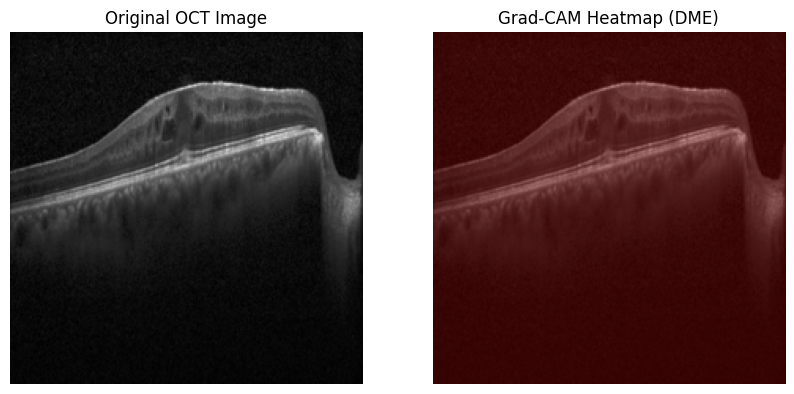

Probabilities → CNV: 0.00, DME: 0.97, DRUSEN: 0.00, NORMAL: 0.03

=== Results for DME-1605248-1 (1).jpeg ===
Detected Class: DME (Confidence 0.97)
Biomarker Detected: Intraretinal cysts / retinal thickening / fluid
Ocular Disease: Diabetic macular edema (complication of diabetic retinopathy)



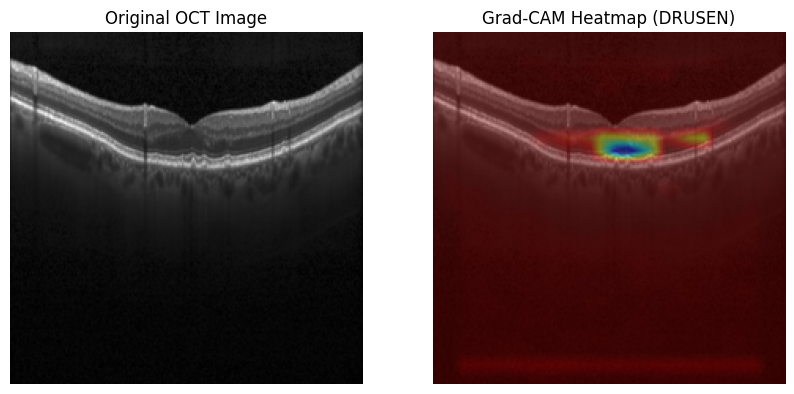

Probabilities → CNV: 0.01, DME: 0.00, DRUSEN: 0.98, NORMAL: 0.01

=== Results for DRUSEN-1094282-1 (1).jpeg ===
Detected Class: DRUSEN (Confidence 0.98)
Biomarker Detected: Sub-RPE drusen deposits ± RPE irregularities
Ocular Disease: Age-related macular degeneration (early/intermediate stage)



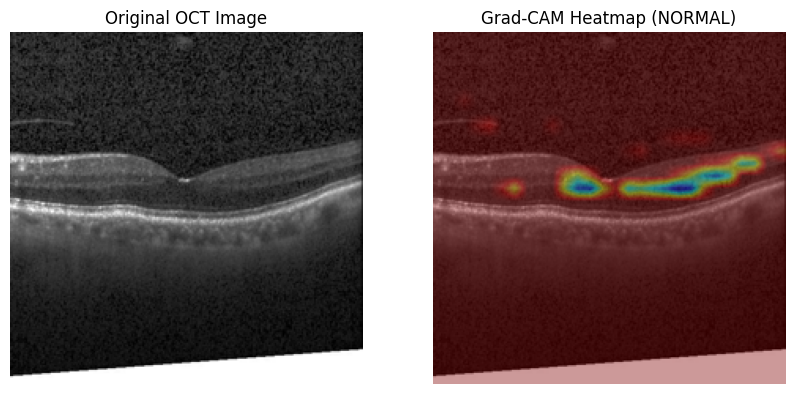

Probabilities → CNV: 0.00, DME: 0.00, DRUSEN: 0.00, NORMAL: 1.00

=== Results for NORMAL-1016042-40.jpeg ===
Detected Class: NORMAL (Confidence 1.00)
Biomarker Detected: No abnormal biomarkers detected
Ocular Disease: Healthy retina



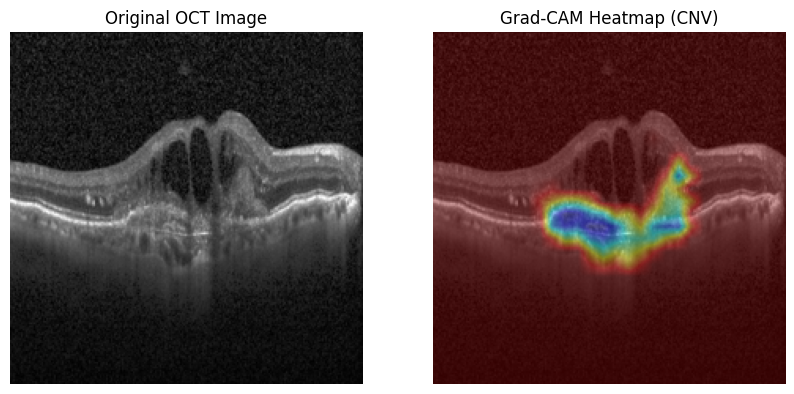

Probabilities → CNV: 1.00, DME: 0.00, DRUSEN: 0.00, NORMAL: 0.00

=== Results for CNV-1016042-191 (2).jpeg ===
Detected Class: CNV (Confidence 1.00)
Biomarker Detected: Choroidal neovascularization (abnormal subretinal vessels)
Ocular Disease: Age-related macular degeneration (wet AMD)



In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from google.colab import files
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

# ------------------------
# Define OCTLiteNet model
# ------------------------
class OCTLiteNet(nn.Module):
    def __init__(self, num_classes=4):
        super(OCTLiteNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 14 * 14, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# ------------------------
# Device and transforms
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


# ------------------------
# Load trained OCTLiteNet
# ------------------------
ckpt_path = "/content/octlitenet_best01.pth"
checkpoint = torch.load(ckpt_path, map_location=device)

model = OCTLiteNet(num_classes=4).to(device)
model.load_state_dict(checkpoint["state_dict"])
model.eval()

# Restore class mapping
class_to_idx = checkpoint["class_to_idx"]
idx_to_class = {v: k for k, v in class_to_idx.items()}
print("Loaded class index mapping:", class_to_idx)


# ------------------------
# Biomarker + disease mapping
# ------------------------
biomarker_map = {
    "CNV": "Choroidal neovascularization (abnormal subretinal vessels)",
    "DME": "Intraretinal cysts / retinal thickening / fluid",
    "DRUSEN": "Sub-RPE drusen deposits ± RPE irregularities",
    "NORMAL": "No abnormal biomarkers detected"
}
disease_map = {
    "CNV": "Age-related macular degeneration (wet AMD)",
    "DME": "Diabetic macular edema (complication of diabetic retinopathy)",
    "DRUSEN": "Age-related macular degeneration (early/intermediate stage)",
    "NORMAL": "Healthy retina"
}


# ------------------------
# Grad-CAM Helper
# ------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        # hook for activations
        def forward_hook(module, inp, out):
            self.activations = out.detach()

        # hook for gradients
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate(self, class_idx):
        # average gradients across channels
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)
        return cam

def predict_image(image_path, show_probs=True, threshold=0.90):
    try:
        img = Image.open(image_path).convert("RGB")
    except Exception as e:
        return f"Cannot open {image_path}: {e}"

    # preprocess
    x = transform(img).unsqueeze(0).to(device)

    # Grad-CAM hook on last conv layer
    gradcam = GradCAM(model, model.features[12])  # last conv layer

    # forward pass (no torch.no_grad here, need gradients)
    logits = model(x)
    probs = torch.softmax(logits, dim=1).detach().cpu().numpy()[0]

    pred_idx = int(probs.argmax())
    pred_class = idx_to_class[pred_idx]
    conf = float(probs[pred_idx])

    # reject if low confidence
    if conf < threshold:
        return (
            f"\n=== WARNING for {os.path.basename(image_path)} ===\n"
            "This may not be a valid OCT image.\n"
            f"Highest confidence: {conf:.2f}"
        )

    # backward for Grad-CAM
    model.zero_grad()
    logits[0, pred_idx].backward(retain_graph=True)
    cam = gradcam.generate(pred_idx)

    # resize CAM to image size
    cam_resized = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)

    # original image as numpy
    img_np = np.array(img.resize((224, 224)))

    # ensure same channel count
    if img_np.ndim == 2:  # grayscale
        img_np = cv2.cvtColor(img_np, cv2.COLOR_GRAY2BGR)

    # overlay heatmap
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # plot results
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img_np)
    axs[0].set_title("Original OCT Image")
    axs[0].axis("off")

    axs[1].imshow(overlay)
    axs[1].set_title(f"Grad-CAM Heatmap ({pred_class})")
    axs[1].axis("off")
    plt.show()

    # show class probabilities
    if show_probs:
        ordered = [f"{idx_to_class[i]}: {probs[i]:.2f}" for i in range(len(probs))]
        print("Probabilities → " + ", ".join(ordered))

    biomarker = biomarker_map[pred_class]
    disease = disease_map[pred_class]

    return (
        f"\n=== Results for {os.path.basename(image_path)} ===\n"
        f"Detected Class: {pred_class} (Confidence {conf:.2f})\n"
        f"Biomarker Detected: {biomarker}\n"
        f"Ocular Disease: {disease}\n"
    )


# ------------------------
# Manual Upload & Predict
# ------------------------
print("Please upload OCT images from your local device...")
uploaded = files.upload()

for filename in uploaded.keys():
    print(predict_image(filename))
